In [ ]:
# pip install pandas

In [2]:
import pandas as pd
import re

# 1. Load the raw data
df = pd.read_csv('FS-data-80475.csv')

# 2. Impute Missing KPI Names (Handles Nulls)
print(f"Rows with missing 'english_name' before: {df['english_name'].isnull().sum()}")
lookup_map = df.dropna(subset=['account_id', 'english_name']) \
               .drop_duplicates(subset=['account_id']) \
               .set_index('account_id')['english_name'] \
               .to_dict()
df['english_name'] = df['english_name'].fillna(df['account_id'].map(lookup_map))
df.dropna(subset=['english_name'], inplace=True)
print(f"Rows with missing 'english_name' after imputing: {df['english_name'].isnull().sum()}")

# 3. Clean and Standardize All KPI Names (Fixes Duplicates & Special Chars)
def clean_kpi_name(name):
    name = re.sub(r'[\(\)\[\]\{\}\n]', '', name) # Remove special characters
    name = re.sub(r'\s+', ' ', name)            # Replace multiple spaces with one
    name = name.strip()                         # Remove leading/trailing whitespace
    return name
df['english_name'] = df['english_name'].apply(clean_kpi_name)
print("\nKPI names have been cleaned and standardized.") 

# 4. Create a Datetime Index
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01')

# 5. Pivot the Data (Now with Clean Columns)
time_series_df = df.pivot_table(
    index='date',
    columns='english_name',
    values='monthly_value',
    aggfunc='sum' # Use 'sum' to combine values from cleaned duplicate names
)

# --- NEW STEP: Remove Columns Containing Only Zeros ---
print(f"\nOriginal number of KPIs (columns): {time_series_df.shape[1]}")

# Identify columns where ALL values are zero
cols_to_remove = time_series_df.columns[(time_series_df == 0).all()]

# Drop these columns from the DataFrame
time_series_df = time_series_df.drop(columns=cols_to_remove)

print(f"Removed {len(cols_to_remove)} columns that only contained zeros.")
print(f"New final number of KPIs (columns): {time_series_df.shape[1]}")
# --- END OF NEW STEP ---


# 6. Save the final cleaned dataset to your system
cleaned_file_path = 'cleaned_model_ready_data.csv'
time_series_df.to_csv(cleaned_file_path)

print(f"\n✅ Cleaned data (with all-zero columns removed) has been saved to '{cleaned_file_path}'")
print("✅ Data is now ready for model training.")
time_series_df.head()

Rows with missing 'english_name' before: 360
Rows with missing 'english_name' after imputing: 0

KPI names have been cleaned and standardized.

Original number of KPIs (columns): 430
Removed 113 columns that only contained zeros.
New final number of KPIs (columns): 317

✅ Cleaned data (with all-zero columns removed) has been saved to 'cleaned_model_ready_data.csv'
✅ Data is now ready for model training.


english_name,# of Productive Bays,# of Working Days,% Return on Operating Investment,% Return on Sales Before Income Tax,% of Labour Sales CP,% of Labour Sales Internal,% of Labour Sales Warranty,+ / -,0 - 3 Months,1 - 30 Days,...,Warranty Hours Sold,Warranty Labour - MITSUBISHI,Warranty Labour Rate,Warranty P&A RO,Warranty Pts. : Warranty Labour Sales,Warranty Rec. / P.D.I. - Mitsubishi,Warranty Receivables - Mitsubishi,Wholesale P&A,Work in Process - Mechanical Labour,Writes
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,3.0,26.0,4.26,-54.95,113.02,74.74,12.24,1390710.0,57685.0,221800.0,...,8.0,1719.0,99.0,3824.0,5.86,20898.0,10449.0,131.0,-3997.0,0.0
2022-02-01,3.0,20.0,1.43,41.56,4.43,-19.60,15.17,-362357.0,75536.0,109348.0,...,23.6,4588.0,99.0,7137.0,-1.62,0.0,12627.0,8928.0,-4586.0,0.0
2022-03-01,3.0,27.0,0.15,8.97,0.97,1.08,-2.05,298578.0,71405.0,251493.0,...,31.0,5881.0,104.0,14548.0,2.39,57108.0,28554.0,10967.0,-7078.0,0.0
2022-04-01,3.0,26.0,-1.90,6.94,37.19,-27.41,-9.78,-173201.0,64648.0,152225.0,...,39.0,7270.0,109.0,23405.0,2.11,60404.0,30202.0,12240.0,-10346.0,0.0
2022-05-01,3.0,26.0,-0.77,0.04,-21.08,19.47,1.61,252293.0,63136.0,137523.0,...,36.2,6667.0,109.0,30549.0,5.50,94140.0,47070.0,9130.0,-11591.0,0.0


In [ ]:
# !pip install statsmodels matplotlib

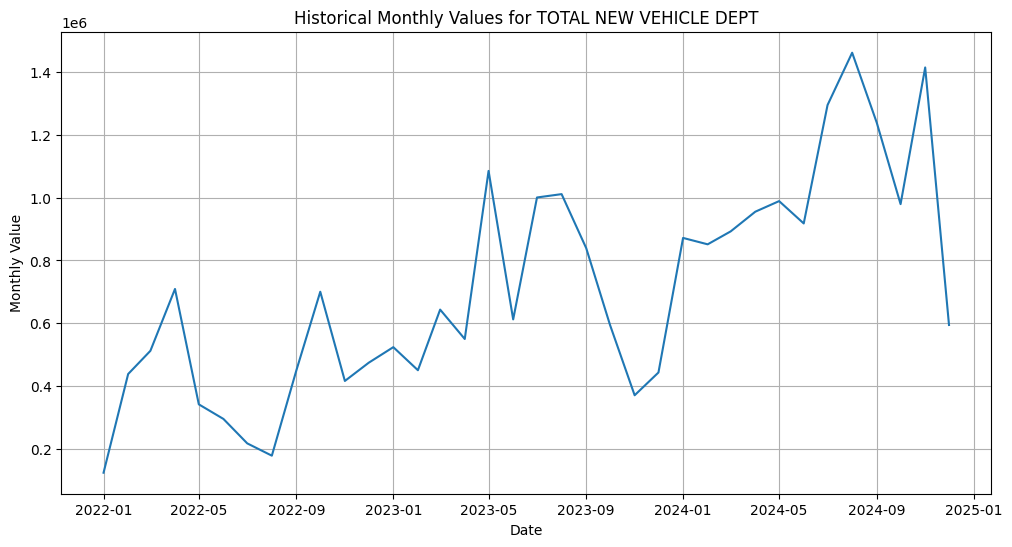

In [3]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Select the KPI you want to forecast. Let's use 'TOTAL NEW VEHICLE DEPT'.
kpi_to_forecast = 'TOTAL NEW VEHICLE DEPT'

# Get the data for just this KPI from your cleaned DataFrame.
# .fillna(0) is a simple way to handle any missing months for this KPI.
kpi_series = time_series_df[kpi_to_forecast].fillna(0)

# Plot the historical data to see the pattern
plt.figure(figsize=(12, 6))
plt.plot(kpi_series)
plt.title(f'Historical Monthly Values for {kpi_to_forecast}')
plt.xlabel('Date')
plt.ylabel('Monthly Value')
plt.grid(True)
plt.show()

In [4]:
# --- Corrected Forecasting Loop for All KPIs ---

import statsmodels.api as sm

# Create an empty DataFrame to store all our forecasts
all_forecasts = pd.DataFrame()
kpi_columns = time_series_df.columns
print(f"Starting forecast for {len(kpi_columns)} KPIs...")

# Loop through each KPI column
for kpi in kpi_columns:
    kpi_series = time_series_df[kpi].fillna(0)
    
    try:
        model = sm.tsa.statespace.SARIMAX(kpi_series,
                                        order=(1, 1, 1),
                                        seasonal_order=(1, 1, 1, 12))
        results = model.fit(disp=False)
        
        # This is the corrected part that gets 3 months
        forecast = results.get_forecast(steps=3)
        predicted_values = forecast.predicted_mean
        
        all_forecasts[kpi] = predicted_values
        
    except Exception as e:
        all_forecasts[kpi] = [0, 0, 0]

print("\n\n✅ All KPIs have been forecasted for 3 months!")

# Save the final forecast results
forecast_file_path = '3_month_forecast_all_kpis.csv'
all_forecasts.to_csv(forecast_file_path)
print(f"✅ Forecast has been saved to '{forecast_file_path}'")

# Display the final forecast to confirm it has 3 rows
all_forecasts.head()

Starting forecast for 317 KPIs...


c:\Users\sharm\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sharm\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sharm\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\sharm\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings



✅ All KPIs have been forecasted for 3 months!
✅ Forecast has been saved to '3_month_forecast_all_kpis.csv'


c:\Users\sharm\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sharm\AppData\Local\Temp\ipykernel_19956\488431651.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_forecasts[kpi] = predicted_values


,# of Productive Bays,# of Working Days,% Return on Operating Investment,% Return on Sales Before Income Tax,% of Labour Sales CP,% of Labour Sales Internal,% of Labour Sales Warranty,+ / -,0 - 3 Months,1 - 30 Days,...,Warranty Hours Sold,Warranty Labour - MITSUBISHI,Warranty Labour Rate,Warranty P&A RO,Warranty Pts. : Warranty Labour Sales,Warranty Rec. / P.D.I. - Mitsubishi,Warranty Receivables - Mitsubishi,Wholesale P&A,Work in Process - Mechanical Labour,Writes
2025-01-01,55.979937,21.281634,-31.175303,34.614637,111.001262,83.481044,8.145990,900633.059003,92744.079711,2.231463e+06,...,7.654154,9132.300104,118.997780,25730.796981,7.178764,95799.605127,47639.375536,20929.198666,26007.499973,45.818853
2025-02-01,59.978595,17.096254,-2.179852,-36.241126,2.904706,-4.212658,3.424727,-144654.649762,100237.974269,1.868450e+06,...,16.244155,9991.761241,118.997781,46580.375356,6.421141,89443.190029,48243.906507,13870.045538,30740.747166,54.270593
2025-03-01,68.975485,19.913872,-6.980748,-2.539744,-3.750460,-2.512137,1.244848,223177.306120,105614.035477,2.185494e+06,...,4.695069,10819.109198,118.997782,35956.701996,-8.661489,107316.462736,53834.641024,28827.473716,30790.472841,86.998173


In [5]:
print("--- Forecasted Values for Jan, Feb, Mar 2025 ---")
all_forecasts.head()



--- Forecasted Values for Jan, Feb, Mar 2025 ---


,# of Productive Bays,# of Working Days,% Return on Operating Investment,% Return on Sales Before Income Tax,% of Labour Sales CP,% of Labour Sales Internal,% of Labour Sales Warranty,+ / -,0 - 3 Months,1 - 30 Days,...,Warranty Hours Sold,Warranty Labour - MITSUBISHI,Warranty Labour Rate,Warranty P&A RO,Warranty Pts. : Warranty Labour Sales,Warranty Rec. / P.D.I. - Mitsubishi,Warranty Receivables - Mitsubishi,Wholesale P&A,Work in Process - Mechanical Labour,Writes
2025-01-01,55.979937,21.281634,-31.175303,34.614637,111.001262,83.481044,8.145990,900633.059003,92744.079711,2.231463e+06,...,7.654154,9132.300104,118.997780,25730.796981,7.178764,95799.605127,47639.375536,20929.198666,26007.499973,45.818853
2025-02-01,59.978595,17.096254,-2.179852,-36.241126,2.904706,-4.212658,3.424727,-144654.649762,100237.974269,1.868450e+06,...,16.244155,9991.761241,118.997781,46580.375356,6.421141,89443.190029,48243.906507,13870.045538,30740.747166,54.270593
2025-03-01,68.975485,19.913872,-6.980748,-2.539744,-3.750460,-2.512137,1.244848,223177.306120,105614.035477,2.185494e+06,...,4.695069,10819.109198,118.997782,35956.701996,-8.661489,107316.462736,53834.641024,28827.473716,30790.472841,86.998173


In [6]:
correlation_matrix = time_series_df.corr()

print("✅ Correlation matrix calculated successfully.")

# Display the top 5 rows and columns of the matrix
correlation_matrix.head()

# forecast_file_path = '3_month_forecast_all_kpis.csv'

# # Use the .to_csv() function to save the DataFrame
# all_forecasts.to_csv(forecast_file_path)

✅ Correlation matrix calculated successfully.


english_name,# of Productive Bays,# of Working Days,% Return on Operating Investment,% Return on Sales Before Income Tax,% of Labour Sales CP,% of Labour Sales Internal,% of Labour Sales Warranty,+ / -,0 - 3 Months,1 - 30 Days,...,Warranty Hours Sold,Warranty Labour - MITSUBISHI,Warranty Labour Rate,Warranty P&A RO,Warranty Pts. : Warranty Labour Sales,Warranty Rec. / P.D.I. - Mitsubishi,Warranty Receivables - Mitsubishi,Wholesale P&A,Work in Process - Mechanical Labour,Writes
english_name,,,,,,,,,,,,,,,,,,,,,
# of Productive Bays,1.000000,-0.569912,0.148612,-0.013016,-0.206725,-0.118658,-0.117818,-0.210926,0.295084,0.607551,...,0.097479,0.472953,0.604814,0.257943,-0.196438,0.360310,0.384496,0.438671,0.838998,0.654541
# of Working Days,-0.569912,1.000000,-0.130598,-0.026676,0.192084,0.171725,-0.022943,0.266231,-0.604854,-0.605773,...,-0.213943,-0.283929,-0.385257,0.037262,0.223324,-0.068066,-0.125803,-0.344747,-0.687440,-0.735086
% Return on Operating Investment,0.148612,-0.130598,1.000000,-0.556686,-0.395059,-0.196054,-0.073457,-0.375098,0.092525,0.105956,...,-0.032047,0.071956,-0.042070,0.088994,-0.061814,-0.167361,-0.163426,-0.150719,0.070697,0.060371
% Return on Sales Before Income Tax,-0.013016,-0.026676,-0.556686,1.000000,0.037674,-0.001632,0.038157,-0.082927,-0.016454,-0.082652,...,-0.004003,0.060680,0.038255,-0.164261,-0.217693,-0.028249,0.072015,0.199582,-0.072794,-0.017866
% of Labour Sales CP,-0.206725,0.192084,-0.395059,0.037674,1.000000,0.256371,0.049532,0.737804,-0.089373,-0.022198,...,0.026794,-0.343106,-0.215001,-0.421040,0.303155,-0.325744,-0.387030,-0.307385,-0.194116,-0.103789


In [ ]:
# !pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org seaborn

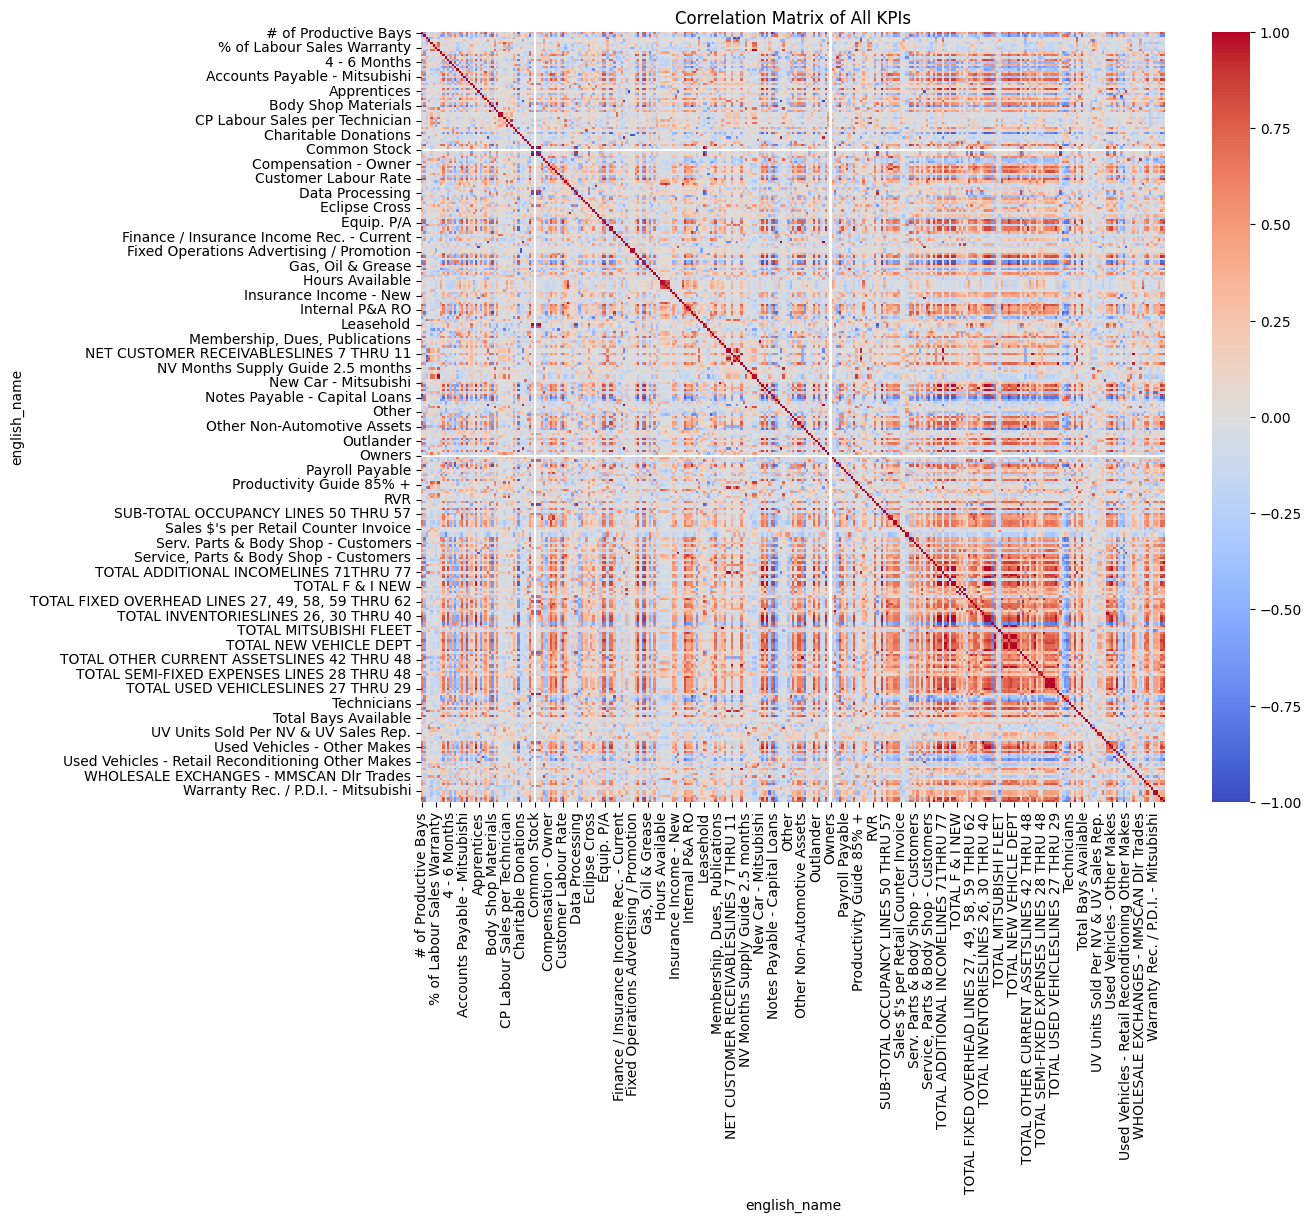

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
sns.heatmap(correlation_matrix, cmap='coolwarm') # 'coolwarm' is a good color map for correlations

plt.title('Correlation Matrix of All KPIs')
plt.show()

In [8]:
# Define a file path for your correlation matrix
correlation_file_path = 'cleaned_correlation_matrix.csv'

# Use the .to_csv() function to save the DataFrame
correlation_matrix.to_csv(correlation_file_path)

print(f"✅ Successfully saved the correlation matrix to: {correlation_file_path}")

✅ Successfully saved the correlation matrix to: cleaned_correlation_matrix.csv


In [ ]:
# # --- FINAL STEP: Model Accuracy Calculation using Train-Test Split ---

# import pandas as pd
# import numpy as np
# import statsmodels.api as sm
# from tqdm import tqdm # A library to show a progress bar

# # 1. LOAD YOUR FINAL CLEANED DATA
# time_series_df = pd.read_csv('cleaned_model_ready_data.csv', index_col='date', parse_dates=True)

# # 2. CHRONOLOGICAL TRAIN-TEST SPLIT
# print("--- Splitting data into Training and Testing sets ---")
# cutoff_date = '2024-01-01'
# train_data = time_series_df[time_series_df.index < cutoff_date]
# test_data = time_series_df[time_series_df.index >= cutoff_date]
# print(f"Training data: {train_data.shape[0]} months, Testing data: {test_data.shape[0]} months")

# # 3. TRAIN ON TRAIN SET, FORECAST FOR TEST SET DURATION
# print("\n--- Training models and forecasting to get accuracy score... ---")
# # This may take a few minutes to run.
# forecasts = pd.DataFrame()
# for kpi in tqdm(train_data.columns, desc="Forecasting KPIs"):
#     train_series = train_data[kpi].fillna(0)
#     try:
#         model = sm.tsa.statespace.SARIMAX(train_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
#         results = model.fit(disp=False)
#         prediction = results.get_forecast(steps=len(test_data))
#         forecasts[kpi] = prediction.predicted_mean
#     except Exception as e:
#         forecasts[kpi] = [0] * len(test_data)

# # 4. CALCULATE ACCURACY (MAPE)
# print("\n--- Calculating final model accuracy ---")
# actuals = test_data[forecasts.columns]
# percentage_error = np.abs((actuals - forecasts) / actuals) * 100
# percentage_error.replace([np.inf, -np.inf], np.nan, inplace=True)
# mape = np.nanmean(percentage_error.values)

# # 5. DISPLAY THE FINAL RESULT
# print("\n" + "="*50)
# print(f"✅ The Model's Mean Absolute Percentage Error (MAPE) is: {mape:.2f}%")
# print("="*50)

In [ ]:
# # --- FINAL ACCURACY: Calculate MAPE on Top 10 KPIs ---

# # 1. Find the 10 KPIs with the highest average historical value
# top_10_kpis = time_series_df.mean().nlargest(10).index.tolist()

# print("--- Calculating a more meaningful MAPE on the Top 10 KPIs ---")
# print("Top 10 KPIs by average value:")
# for kpi in top_10_kpis:
#     print(f"  - {kpi}")

# # 2. Filter your actuals and forecasts to only include these top KPIs
# actuals_top_10 = test_data[top_10_kpis]
# forecasts_top_10 = forecasts[top_10_kpis]

# # 3. Recalculate the MAPE
# percentage_error_top_10 = np.abs((actuals_top_10 - forecasts_top_10) / actuals_top_10) * 100
# percentage_error_top_10.replace([np.inf, -np.inf], np.nan, inplace=True)
# mape_top_10 = np.nanmean(percentage_error_top_10.values)

# # 4. DISPLAY THE FINAL, MEANINGFUL RESULT
# print("\n" + "="*50)
# print(f"✅ The MAPE for the Top 10 most significant KPIs is: {mape_top_10:.2f}%")
# print("="*50)